## Monte carlo Lab 1

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.stats import norm, lognorm # gives us the normal and log normal pdf,cdf and inverse cdf (ppf,point percent function)
from scipy.stats.mstats import gmean #geomeetric mean

SyntaxError: invalid syntax (3104577355.py, line 1)

## Task 1 : Call and put option





Let S(0) = 100, r = 0.03, T = 1 (year), 𝜎 = 20% and 𝐾 ∈ {70, 100, 130}

a) Calculate the option price using the Black-Scholes formula

In [2]:
def BlackScholes(S, T, K, sigma,r):
  d1 = 1/(sigma*(T ** (1/2)))* (np.log(S/K) + (r + (sigma ** 2) / 2 ) * T )
  d2 = d1 - sigma * T ** (1/2)
  price = S * norm.cdf(d1) - np.exp(-r*T) * norm.cdf(d2) *K
  return price

In [3]:
def PutCallParity(CallPrice,T , r, S, K ):
  # Take Call pricces and calculate the put prices
  p = CallPrice - S + K * np.exp(-r * T)
  return p

def CallPutParity(PutPrice,T , r, S, K ):
  # Takes put price and calculates the call price
  c = PutPrice + S - K * np.exp(-r * T)
  return c

In [4]:
S_0 = 100 ; r = 0.03 ; T = 1 ; sigma = 0.2; K = [70,100,130]


In [5]:
CallPrices = [BlackScholes(S_0, T, k, sigma,r) for k in K]

for i, p in enumerate(CallPrices):
  print(f"Call option price at strike {K[i]} is:  {p.round(3)}")

Call option price at strike 70 is:  32.235
Call option price at strike 100 is:  9.413
Call option price at strike 130 is:  1.358


In [9]:
PutPrices = [PutCallParity(CallPrices[i], T, r, S_0, k) for i, k in enumerate(K)]
for i, p in enumerate(PutPrices):
  print(f"Put option price at strike {K[i]} is:  {p.round(3)}")

Put option price at strike 70 is:  0.166
Put option price at strike 100 is:  6.458
Put option price at strike 130 is:  27.516


b) Study how the price for the call and put option (for K = 100) depends on the volatility, time to maturity and the
interest rate by plotting the option values against these variables in three separate plots. Vary
- the volatility in the range [1%,50%] with steps of size 1%,
- the time to maturity in the range [1/12,5] with steps of size 1/12, and
- the interest rate in the range [0, 0.1] with steps of size 0.01.

In [9]:
S_0 = 100 ; r = 0.03 ; T = 1 ; K = 100; sigma = 0.2

In [ ]:
SigmaVec = np.arange(0.01, 0.5, 0.01)
TVec = np.arange(1,12.5,1/12)
InterestVec = np.arange(0,0.1,0.01)

In [ ]:
# Prices when varying sigma
CallPriceSigma = BlackScholes(S_0, T, K, SigmaVec, r )
PutPriceSigma = PutCallParity(CallPriceSigma, T, r, S_0, K)

# Prices when varying time to maturity
CallPriceTime = BlackScholes(S_0, TVec, K, sigma, r)
PutPriceTime = PutCallParity(CallPriceTime, TVec, r, S_0, K)

# Prices when varying interest rate
CallPriceInterest = BlackScholes(S_0, T, K, sigma, InterestVec)
PutPriceInterest = PutCallParity(CallPriceInterest, T, InterestVec, S_0, K)



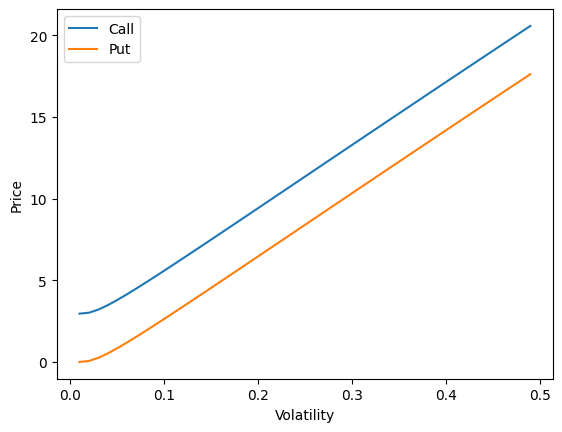

In [ ]:
plt.plot(SigmaVec, CallPriceSigma, label = 'Call')
plt.plot(SigmaVec, PutPriceSigma, label = 'Put')
plt.xlabel('Volatility')
plt.ylabel('Price')
plt.legend()

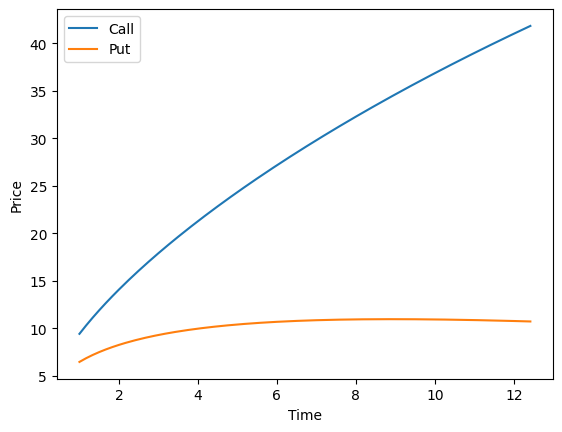

In [ ]:
plt.plot(TVec, CallPriceTime, label = 'Call')
plt.plot(TVec, PutPriceTime, label = 'Put')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

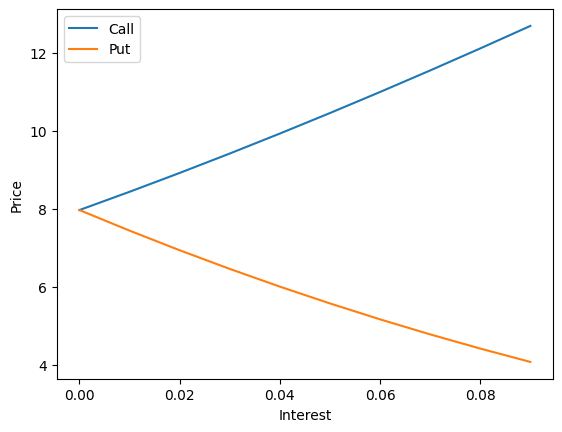

In [ ]:
plt.plot(InterestVec, CallPriceInterest, label = 'Call');
plt.plot(InterestVec, PutPriceInterest , label = 'Put');
plt.xlabel('Interest')
plt.ylabel('Price')
plt.legend();

c) Calculate the price using standard MC, determine a 95% confidence interval

In [6]:
def StockTrajectory(n_paths, n_years, timesteps, S_0, Z,r):
  dt = n_years/timesteps
  S = S_0 * np.ones((int(n_paths),n_years * timesteps +1))
  for n in range(int(n_paths)):
    for t in range(1,Z.shape[1]):
      S[n, t] = S[n,t-1] * np.exp((r-0.5 * sigma ** 2) * dt + np.sqrt(dt) * sigma * Z[n,t])
  return S

def CalculateCallPrices(S,n_years,K,r,paths):
  C_n_vector = np.zeros(len(K))
  confint_call = np.zeros(len(K))
  for i, k in enumerate(K):
    C = np.exp(-r*n_years) * np.maximum(S[:,-1] - k , 0)
    C_n = np.mean(C)
    C_n_vector[i] = C_n
    confint_call[i] = np.quantile(Z, 0.975)*np.std(C)/(paths ** (1/2))
    #print(f"Call option price estimate for strike {k} is: {C_n:.3f} +/- {confint_call[i]}")
  return C_n_vector, confint_call


def CalculatePutPrices(S,n_years,K,r,paths):
  P_n_vector = np.zeros(len(K))
  confint_put = np.zeros(len(K))
  for i, k in enumerate(K):
    P = np.exp(-r*n_years) * np.maximum(k-S[:,-1] , 0)
    P_n = np.mean(P)
    P_n_vector[i] = P_n
    confint_put[i] = np.quantile(Z, 0.975)*np.std(P) /(paths ** (1/2))
    #print(f"Put option price estimate for strike {k} is: {P_n:.3f} +/- {confint_put[i]} ")
  return P_n_vector, confint_put

In [12]:
S_0 = 100
n_years = 1
timesteps = 1
n_paths = 20000
K = np.array([70, 100, 130])
Z = np.random.standard_normal((int(n_paths),n_years * timesteps +1))

S = StockTrajectory(n_paths, n_years, timesteps, S_0, Z,r)

CallPrice, Confint_call =  CalculateCallPrices(S,n_years,K,r,n_paths)
PutPrice, Confint_put =  CalculatePutPrices(S,n_years,K,r,n_paths)


print('Call prices', CallPrice  , '+/-', Confint_call)
print('Put prices' ,PutPrice    , '+/-', Confint_put)



Call prices [32.36784148  9.51049546  1.39524827] +/- [0.27911411 0.19868917 0.07897973]
Put prices [ 0.15224336  6.40826334 27.40638216] +/- [0.01559556 0.12965888 0.24271725]


d) Calculate the price using antithetic variables and determine a 95% confidence interval. Here you should only use 10000 simulations to make the comparison fair.

In [10]:
# Antithetic variables
S_0 = 100
n_years = 1
timesteps = 1
n_paths = 10000
K = np.array([70, 100, 130])

Z = np.random.standard_normal((int(n_paths),n_years * timesteps +1))

S_plus = StockTrajectory(n_paths, n_years, timesteps, S_0, Z,r)
S_minus = StockTrajectory(n_paths, n_years, timesteps, S_0, -Z,r)

def AntitheticCall(S_plus, S_minus,n_years,K,r,paths):
  C_av_vector = np.zeros(len(K))
  confint_call_av = np.zeros(len(K))
  for i, k in enumerate(K):
    C_plus = np.exp(-r*n_years) * np.maximum(S_plus[:,-1] - k , 0)
    C_minus = np.exp(-r*n_years) * np.maximum(S_minus[:,-1] - k , 0)
    C_hat = (C_plus + C_minus)/2
    C_av = np.mean(C_hat)
    C_av_vector[i] = C_av
    confint_call_av[i] = np.quantile(Z, 0.975)*np.std(C_hat)/(paths ** (1/2))
    #print(f"Call option price estimate for strike {k} is: {C_av:.3f} +/- {confint_call_av[i]}")
  return C_av_vector, confint_call_av

def AntitheticPut(S_plus, S_minus,n_years,K,r,paths):
  P_av_vector = np.zeros(len(K))
  confint_put_av = np.zeros(len(K))
  for i, k in enumerate(K):
    P_plus = np.exp(-r*n_years) * np.maximum(k-S_plus[:,-1] , 0)
    P_minus = np.exp(-r*n_years) * np.maximum(k-S_minus[:,-1] , 0)
    P_hat = (P_plus + P_minus)/2
    P_av = np.mean(P_hat)
    P_av_vector[i] = P_av
    confint_put_av[i] = np.quantile(Z, 0.975)*np.std(P_hat)/(paths ** (1/2))
    #print(f"Put option price estimate for strike {k} is: {P_av:.3f} +/- {confint_put_av[i]}")
  return P_av_vector, confint_put_av

print(AntitheticCall(S_plus, S_minus,n_years,K,r,n_paths))
print(AntitheticPut(S_plus, S_minus,n_years,K,r,n_paths))



(array([32.16960688,  9.30555836,  1.28059505]), array([0.06465672, 0.13966516, 0.07032003]))
(array([ 0.14734958,  6.39666707, 27.48506976]), array([0.01496694, 0.09062315, 0.02799537]))


e) Produce a comparison plot for the call option with K = 100 (including: exact price, SMC-price, AV-price)

In [11]:
S_0 = 100
n_years = 1
timesteps = 1
n_paths = np.linspace(10000,100000,10)
K = np.array([70, 100, 130])

# Define arrays
SMC_Call = np.zeros((len(n_paths),len(K)))
AV_Call = np.zeros((len(n_paths),len(K)))
SMC_Put = np.zeros((len(n_paths),len(K)))
AV_Put = np.zeros((len(n_paths),len(K)))

SMC_Call_CI_vec = np.zeros((len(n_paths),len(K)))
AV_Call_CI_vec = np.zeros((len(n_paths),len(K)))
SMC_Put_CI_vec = np.zeros((len(n_paths),len(K)))
AV_Put_CI_vec = np.zeros((len(n_paths),len(K)))

for i, sims in enumerate(n_paths):
  paths = int(sims);
  Z = np.random.standard_normal((int(paths),n_years+1))
  #### SMC
  S = StockTrajectory(paths, n_years, timesteps, S_0, Z, r)
  SMC_Call_price, SMC_Call_CI = CalculateCallPrices(S,n_years,K,r,paths)
  SMC_Put_price, SMC_Put_CI = CalculatePutPrices(S,n_years,K,r,paths)

  #### AV
  S_plus = StockTrajectory(paths, n_years, timesteps, S_0, Z, r)
  S_minus = StockTrajectory(paths, n_years, timesteps, S_0, -Z, r)
  AV_Call_price, AV_Call_CI = AntitheticCall(S_plus, S_minus,n_years,K,r,paths)
  AV_Put_price, AV_Put_CI = AntitheticPut(S_plus, S_minus,n_years,K,r,paths)

  for j in range(len(K)):
    SMC_Call[i,j] = SMC_Call_price[j]
    SMC_Put[i,j] = SMC_Put_price[j]
    AV_Call[i,j] = AV_Call_price[j]
    AV_Put[i,j] = AV_Put_price[j]

    SMC_Call_CI_vec[i,j] = SMC_Call_CI[j]
    SMC_Put_CI_vec[i,j] = SMC_Put_CI[j]
    AV_Call_CI_vec[i,j] = AV_Call_CI[j]
    AV_Put_CI_vec[i,j] = AV_Put_CI[j]





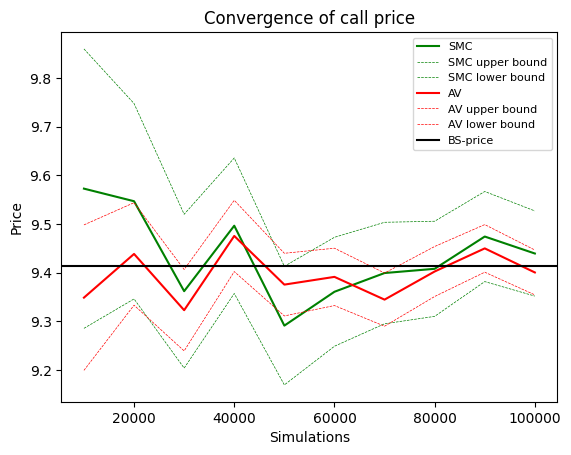

In [ ]:
# Plot call
plt.plot(n_paths,SMC_Call[:,1], label='SMC',color = 'green');
plt.plot(n_paths,SMC_Call[:,1]+ SMC_Call_CI_vec[:,1], label='SMC upper bound', linestyle='--',color = 'green',linewidth=0.5);
plt.plot(n_paths,SMC_Call[:,1]- SMC_Call_CI_vec[:,1], label='SMC lower bound', linestyle='--',color = 'green',linewidth=0.5);

plt.plot(n_paths,AV_Call[:,1], label='AV',color = 'red');
plt.plot(n_paths,AV_Call[:,1]+ AV_Call_CI_vec[:,1], label='AV upper bound', linestyle='--',color = 'red',linewidth=0.5);
plt.plot(n_paths,AV_Call[:,1]- AV_Call_CI_vec[:,1], label='AV lower bound', linestyle='--',color = 'red',linewidth=0.5);
plt.axhline(y=CallPrices[1], color='k', linestyle='-', label='BS-price');
plt.xlabel('Simulations')
plt.ylabel('Price')
plt.title('Convergence of call price')
plt.legend(fontsize=8);

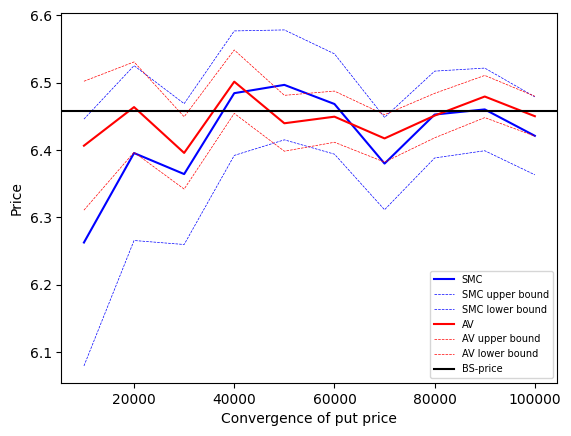

In [ ]:
# Plot put
plt.plot(n_paths,SMC_Put[:,1], label='SMC',color = 'blue');
plt.plot(n_paths,SMC_Put[:,1]+ SMC_Put_CI_vec[:,1], label='SMC upper bound', linestyle='--',color = 'blue',linewidth=0.5);
plt.plot(n_paths,SMC_Put[:,1]- SMC_Put_CI_vec[:,1], label='SMC lower bound', linestyle='--',color = 'blue',linewidth=0.5);

plt.plot(n_paths,AV_Put[:,1], label='AV',color = 'red');
plt.plot(n_paths,AV_Put[:,1]+ AV_Put_CI_vec[:,1], label='AV upper bound', linestyle='--',color = 'red',linewidth=0.5);
plt.plot(n_paths,AV_Put[:,1]- AV_Put_CI_vec[:,1], label='AV lower bound', linestyle='--',color = 'red',linewidth=0.5);
plt.axhline(y=PutPrices[1], color='k', linestyle='-', label='BS-price');
plt.xlabel('Simulations')
plt.ylabel('Price')
plt.xlabel('Convergence of put price')
plt.legend(fontsize=7);

## Task 2 : Asian Call

Choose parameters as in problem 1 with $0 = 𝑡_0 < 𝑡_1 < ⋯ < 𝑡_𝑚 = 𝑇,$ where $ 𝑡_𝑖 − 𝑡_{𝑖−1} = \frac{1}{𝑚}$ for $𝑚 ∈ \{12, 52\}$, for the following two types of Asian options


- i) Asian call based on the geometric mean:
  $ Payoff = \big(\sqrt[m]{S(t_1) \cdot S(t_m)} - K \big)^{+}$

  - a) Calculate the price using the exact formula



In [2]:
def geometric_asian_exact(m, S, sigma, T, K, r, dt):
  t = np.arange(0, T+dt, dt)
  t_bar = 0.5
  C = np.zeros(len(K))
  bar = np.zeros(m)

  for i in range(1, m):
      bar[i] = bar[i-1] + (2*i-1)*t[m+1-i]

  sigma_bar_2 = (sigma * 2) / ((m * 2)*t_bar) * bar[-1]
  delta = 0.5*sigma**2 - 0.5*sigma_bar_2

  for i, k in enumerate(K):
      d1_star = (np.log(S/k) +(r-delta+0.5*sigma_bar_2)*t_bar) / (np.sqrt(sigma_bar_2)*np.sqrt(t_bar))
      d2_star = d1_star - np.sqrt(sigma_bar_2)*np.sqrt(t_bar)
      C[i] = np.exp(-r*(T-t_bar)) * (np.exp(-delta*t_bar) * S * norm.cdf(d1_star) - np.exp(-r*t_bar) * k * norm.cdf(d2_star))

  return C;

In [3]:
S0 = 100; r = 0.03; T = 1; sigma = 0.20; m = [12, 52]
K = np.array([70, 100, 130])

dt = [1/m[0], 1/m[1]]

t = np.arange(0, T+dt[1], dt[1])

C_weeks = geometric_asian_exact(m[1], S0, sigma, T, K, r, dt[1])
C_months = geometric_asian_exact(m[0], S0, sigma, T, K, r, dt[0])
print(f'Exact price                           K=70,     K=100,    K=130')
print(f'Option price for 52 weeks  at strike: {C_weeks[0]:.3f},  {C_weeks[1]:.3f},  {C_weeks[2]:.3f} ')
print(f'Option price for 12 months at strike: {C_months[0]:.3f},   {C_months[1]:.3f},   {C_months[2]:.3f}')

Exact price                           K=70,     K=100,    K=130
Option price for 52 weeks  at strike: 528.234,  512.617,  498.871 
Option price for 12 months at strike: 92.470,   75.788,   62.862


In [ ]:
def geometric_asian_exact(m, S, sigma, T, K, r, dt):
    t = np.arange(0, T+dt, dt)
    t_bar = 0.5
    C = np.zeros(len(K))
    bar = np.zeros(m)

    for i in range(1, m):
        bar[i] = bar[i-1] + (2*i-1)*t[m+1-i]

    sigma_bar_2 = (sigma * 2) / ((m * 2)*t_bar) * bar[-1]
    delta = 0.5*sigma**2 - 0.5*sigma_bar_2

    for i, k in enumerate(K):
        d1_star = (np.log(S/k) +(r-delta+0.5*sigma_bar_2)*t_bar) / (np.sqrt(sigma_bar_2)*np.sqrt(t_bar))
        d2_star = d1_star - np.sqrt(sigma_bar_2)*np.sqrt(t_bar)
        C[i] = np.exp(-r*(T-t_bar)) * (np.exp(-delta*t_bar) * S * norm.cdf(d1_star) - np.exp(-r*t_bar) * k * norm.cdf(d2_star))

    return C;

In [ ]:
S0 = 100; r = 0.03; T = 1; sigma = 0.20; m = [12, 52]
K = np.array([70, 100, 130])

S_weeks = S0
S_months = S0
dt = [1/m[0], 1/m[1]]

t = np.arange(0, T+dt[1], dt[1])
t_bar = 0.5
C = np.zeros(len(K))
bar = np.zeros(m[1])

C_weeks = geometric_asian_exact(m[1], S_weeks, sigma, T, K, r, dt[1])
C_months = geometric_asian_exact(m[0], S_months, sigma, T, K, r, dt[0])

print(f'Option price estimate for 52 weeks at strike {K}: {C_weeks[0]:.3f}  {C_weeks[1]:.3f}  {C_weeks[2]:.3f} ')
print(f'Option price estimate for 12 months at strike {K}: {C_months[0]:.3f}  {C_months[1]:.3f}  {C_months[2]:.3f}')


Option price estimate for 52 weeks at strike [ 70 100 130]: 528.234  512.617  498.871 
Option price estimate for 12 months at strike [ 70 100 130]: 92.470  75.788  62.862


- ii) Asian call based on the arithmetic mean:

  $ Payoff = \big(\frac{S(t_1)+ ... + S(t_m)}{m} - K \big)^{+}$

  - a) Calculate the price using standard MC for all strikes

In [ ]:
def AsianGeometricPayoff(S,K,n_years,r):
  simulations = S.shape[0] # Number of rows
  row_length = S.shape[1]  # Row length
  payoff = np.zeros((simulations,len(K)))
  for index, k in enumerate(K):
    S_prod = np.prod(S, axis = 1) # Rowise product of the prices
    payoff[:,index] =  np.exp(-r*n_years) * np.maximum(np.power(S_prod, 1/row_length) - k, 0) # Payoff calculation
  return payoff

def AsianAritmetricPayoff(S,K,n_years,r):
  simulations = S.shape[0] # Number of rows
  row_length = S.shape[1]  # Row length
  payoff = np.zeros((simulations,len(K)))
  for index, k in enumerate(K):
    S_sum = np.sum(S, axis = 1) # Rowise sum of the prices
    payoff[:,index] =  np.exp(-r*n_years) * np.maximum((S_sum/row_length) - k, 0) # Payoff calculation
  return payoff

def AsianPrice(InitialPrice,Strikes,Interest,Sigma,StartTime,FinalTime,TimeStepsPerYear,Simulations):
  ###
  #  Function for calculating the price of an asian option.
  ###
  dt = 1/(FinalTime*TimeStepsPerYear) # Time step in years
  NumberOfSteps = FinalTime*TimeStepsPerYear
  # Generate random numbers
  Z = np.random.standard_normal((int(Simulations), int(NumberOfSteps + 1)))
  S = StockTrajectory(Simulations, FinalTime, TimeStepsPerYear, InitialPrice, Z, Interest)

  payoff = AsianAritmetricPayoff(S,Strikes,FinalTime,Interest)

  # Calculating confidence intervals
  SMC_Asian_CI = np.zeros(len(Strikes))
  for k in range(len(Strikes)):
    SMC_Asian_CI[k] = np.quantile(Z, 0.975)*np.std(payoff[:,k])/(Simulations ** (1/2))

  A_n_matrix = np.mean(payoff, axis = 0) # Average payoff
  return A_n_matrix , SMC_Asian_CI


In [ ]:
# Standard Monte Carlo
# Price for all simulations and number of time partitions and strikes
S_0 = 100 ; r = 0.03 ;t_0 = 0 ; T = 1 ; sigma = 0.2; K = np.array([70,100,130])
m = np.array([12,52]) # Year Partitions
n_paths = np.linspace(10000,100000,10)

Asian12 = np.zeros((len(n_paths),len(K)))
Asian52 = np.zeros((len(n_paths),len(K)))
Asian12_CI = np.zeros((len(n_paths),len(K)))
Asian52_CI = np.zeros((len(n_paths),len(K)))
for j in range(len(m)):
  print(f'Time partition is {m[j]}                  K=70,   K=100, K=130')
  for i in range(len(n_paths)):
    a , CI = AsianPrice(S_0,K,r,sigma,t_0,T,m[j],n_paths[i])
    print(f'  The price at {n_paths[i]} simulations is {a[0]:.3f}, {a[1]:.3f}, {a[2]:.3f} with CI:s {CI}')

    if j == 0 :
      for k in range(len(K)):
        Asian12[i,k] = a[k]
        Asian12_CI[i,k] = CI[k]
    else:
      for k in range(len(K)):
        Asian52[i,k] = a[k]
        Asian52_CI[i,k] = CI[k]

  print('---------------------------------------------------------')


Time partition is 12                  K=70,   K=100, K=130
  The price at 10000.0 simulations is 30.522, 5.144, 0.064 with CI:s [0.21746289 0.14543137 0.01471271]
  The price at 20000.0 simulations is 30.505, 5.140, 0.086 with CI:s [0.15590258 0.10520992 0.01331211]
  The price at 30000.0 simulations is 30.507, 5.163, 0.076 with CI:s [0.12700955 0.08524261 0.00980935]
  The price at 40000.0 simulations is 30.550, 5.200, 0.089 with CI:s [0.11137354 0.07535385 0.00990349]
  The price at 50000.0 simulations is 30.597, 5.198, 0.078 with CI:s [0.09850987 0.06637666 0.00790612]
  The price at 60000.0 simulations is 30.570, 5.186, 0.085 with CI:s [0.09004849 0.06076027 0.00756715]
  The price at 70000.0 simulations is 30.596, 5.204, 0.080 with CI:s [0.08337719 0.0563187  0.00661094]
  The price at 80000.0 simulations is 30.573, 5.172, 0.085 with CI:s [0.07772973 0.05258113 0.00677376]
  The price at 90000.0 simulations is 30.510, 5.167, 0.078 with CI:s [0.07366295 0.04947297 0.00579426]
  The

- b) Calculate the price using a control variate (the geometric asian call) for all strikes

In [4]:
def AsianGeometricPayoff(S,K,n_years,r):
  simulations = S.shape[0] # Number of rows
  row_length = S.shape[1]  # Row length
  payoff = np.zeros((simulations,len(K)))
  for index, k in enumerate(K):
    S_prod = np.prod(S, axis = 1) # Rowise product of the prices
    payoff[:,index] =  np.exp(-r*n_years) * np.maximum(np.power(S_prod, 1/row_length) - k, 0) # Payoff calculation
  return payoff

def AsianAritmetricPayoff(S,K,n_years,r):
  simulations = S.shape[0] # Number of rows
  row_length = S.shape[1]  # Row length
  payoff = np.zeros((simulations,len(K)))
  for index, k in enumerate(K):
    S_sum = np.sum(S, axis = 1) # Rowise sum of the prices
    payoff[:,index] =  np.exp(-r*n_years) * np.maximum((S_sum/row_length) - k, 0) # Payoff calculation
  return payoff

def CvEstimator(Y,X,b,Exactvalues):
  # Calculate mean of payoffs
  Y_m = np.mean(Y, axis = 0)
  X_m = np.mean(X, axis = 0)
  Y_hat = np.zeros((Exactvalues.shape[0]))
  for k in range((Exactvalues.shape[0])):
    Y_hat[k] = Y_m[k] - b[k] * (X_m[k] - Exactvalues[k])
  return Y_hat

def CalculateB(Y,X):
  # Calculate mean of payoffs
  Y_m = np.mean(Y, axis = 0)
  X_m = np.mean(X, axis = 0)

  # De-mean Y and X
  Y_dm = Y - Y_m
  X_dm = X - X_m

  # Taking the sum of the matrix columns in b
  b_top = np.mean((Y_dm * X_dm), axis = 0)
  b_bottom = np.mean((X_dm * X_dm), axis = 0)
  # Calculating b for all strikes
  b = b_top/b_bottom
  return b





In [5]:
# CV price
# Price for all simulations and number of time partitions and strikes
S_0 = 100 ; r = 0.03 ;t_0 = 0 ; T = 1 ; sigma = 0.2; K = np.array([70,100,130])
m = np.array([12,52]) # Year Partitions
n_paths = np.linspace(10000,100000,10)

# True values of geometric payoff
C_SMC = np.array([[30.313,  5.313,  0.093], [30.272,  5.156,  0.075]]) # Row 1 -> m12, Row 2 -> m52

# To test
#Simulations = 1000#n_paths[0]

# Result matrices
AAC_CV_12 = np.zeros((len(n_paths), len(K)))
AAC_CV_52 = np.zeros((len(n_paths), len(K)))
#AAC_CV_12_CI = np.zeros((len(n_paths), len(K)))
#AAC_CV_52_CI = np.zeros((len(n_paths), len(K)))

GAC_SMC_12 = np.zeros((len(n_paths),len(K)))
GAC_SMC_52 = np.zeros((len(n_paths),len(K)))
GAC_SMC_12_CI = np.zeros((len(n_paths),len(K)))
GAC_SMC_52_CI = np.zeros((len(n_paths),len(K)))

AAC_SMC_12 = np.zeros((len(n_paths),len(K)))
AAC_SMC_52 = np.zeros((len(n_paths),len(K)))
AAC_SMC_12_CI = np.zeros((len(n_paths),len(K)))
AAC_SMC_52_CI = np.zeros((len(n_paths),len(K)))

for i in range(len(m)):
  for n, Simulations in enumerate(n_paths):

    # Create stock trajectories
    dt = 1/(m[i]) # Time step in years
    NumberOfSteps = T*m[i]

    # Generate random numbers and stock paths
    Z = np.random.standard_normal((int(Simulations), int(NumberOfSteps + 1)))
    S = StockTrajectory(Simulations, T, m[i], S_0, Z, r)

    # Create payoff matrices
    Y = AsianAritmetricPayoff(S,K,T,r) # Aritmetic payoff matrix
    X = AsianGeometricPayoff(S,K,T,r) # Geometric payoff matrix

    # Calculate b for the different strikes
    b = CalculateB(Y,X)



    for k in range(len(K)):
      # Calculate the Cv prices for the different strikes
      Y_hat = CvEstimator(Y,X,b,C_SMC[i,:])

      if i == 0:
        AAC_CV_12[n,k] = Y_hat[k] # CV prices for m = 12
        #AAC_CV_12_CI[n,k] = np.quantile(Z, 0.975)*np.std(Y_hat[:,k])/(Simulations ** (1/2))###

        GAC_SMC_12[n,k] = np.mean(X, axis = 0)[k]
        GAC_SMC_12_CI[n,k]

        AAC_SMC_12[n,k]  = np.mean(Y, axis = 0)[k]
        AAC_SMC_12_CI[n,k] =  np.quantile(Z, 0.975)*np.std(Y[:,k])/(Simulations ** (1/2))

      else:
        AAC_CV_52[n,k] = Y_hat[k] # CV prices for m = 12
        #AAC_CV_52_CI[n,k] = np.quantile(Z, 0.975)*np.std(Y_hat[:,k])/(Simulations ** (1/2))###

        GAC_SMC_52[n,k] = np.mean(X, axis = 0)[k]
        GAC_SMC_52_CI[n,k] = np.quantile(Z, 0.975)*np.std(X[:,k])/(Simulations ** (1/2))

        AAC_SMC_52[n,k] =  np.mean(Y, axis = 0)[k]
        AAC_SMC_52_CI[n,k] =  np.quantile(Z, 0.975)*np.std(Y[:,k])/(Simulations ** (1/2))









In [ ]:
print(AAC_CV_52)
print(GAC_SMC_52)
print(AAC_SMC_52)


  
  - c) Produce a comparison plot for K = 100 and m = 52 (including SMC-price and CV-price)

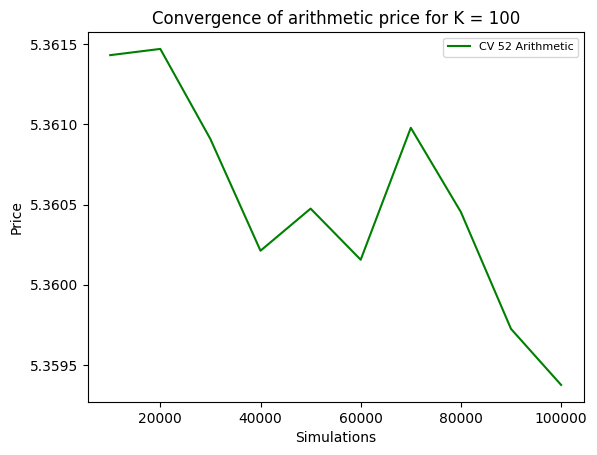

In [16]:
# Plot
# plt.plot(n_paths,Asian12[:,1], label='SMC 12',color = 'blue');
# plt.plot(n_paths,Asian12[:,1]+ Asian12_CI[:,1], label='SMC 12 upper bound', linestyle='--',color = 'blue',linewidth=0.5);
# plt.plot(n_paths,Asian12[:,1]- Asian12_CI[:,1], label='SMC 12 lower bound', linestyle='--',color = 'blue',linewidth=0.5);

plt.plot(n_paths,AAC_CV_52[:,1], label='CV 52 Arithmetic',color = 'Green');
#plt.plot(n_paths,GAC_CV_52[:,1]+ GAC_SMC_52_CI[:,1], label='SMC 52 upper bound', linestyle='--',color = 'red',linewidth=0.5);
#plt.plot(n_paths,GAC_CV_52[:,1]- GAC_SMC_52_CI[:,1], label='SMC 52 lower bound', linestyle='--',color = 'red',linewidth=0.5);


#plt.plot(n_paths,AAC_SMC_52[:,1], label='SMC 52 Arithmetic',color = 'red');
#plt.plot(n_paths,AAC_SMC_52[:,1]+ AAC_SMC_52_CI[:,1], label='SMC 52 upper bound', linestyle='--',color = 'red',linewidth=0.5);
#plt.plot(n_paths,AAC_SMC_52[:,1]- AAC_SMC_52_CI[:,1], label='SMC 52 lower bound', linestyle='--',color = 'red',linewidth=0.5);

#plt.plot(n_paths,GAC_SMC_52[:,1], label='SMC 52 Geometric',color = 'Blue');
#plt.plot(n_paths,GAC_SMC_52[:,1]+ GAC_SMC_52_CI[:,1], label='SMC 52 upper bound', linestyle='--',color = 'red',linewidth=0.5);
#plt.plot(n_paths,GAC_SMC_52[:,1]- GAC_SMC_52_CI[:,1], label='SMC 52 lower bound', linestyle='--',color = 'red',linewidth=0.5);


#plt.axhline(y=C_SMC[1,1], color='k', linestyle='-', label='Exact geometric price');

plt.xlabel('Simulations')
plt.ylabel('Price')
plt.title('Convergence of arithmetic price for K = 100')
plt.legend(fontsize = 8);

*Discussion:*
- Why is the price of the geometric option lower than the arithmetic option?
- Why does the price decrease as m increase

Discussion.
 Blablabla

## Task 3 : Barrier option, down-and-in-call


$Payoff = 1_{𝜏(b) ≤ T} \cdot (S(T) - K)^+ $ where $\tau (b) = min \{ t_{𝑖}: S(t_{𝑖}) \leq b \}$

Let $S(0) = 100, r = 0.03, T = 1 (year), K = 100, \sigma \in \{0.2, 0.4\}, 𝑏 = 80$ and $𝑚 ∈ \{12, 52\}$.


a) Calculate the price using standard MC



In [ ]:
# a)
S_0 = 100 ; r = 0.03; T = 1; K = 100; sigma = np.array([0.2,0.4]); b = 80; m =  np.array([12,52])
simulations = 200000; n_years = T
dt = 1/m

def DownInCall(S, b, K):
  # Function that calculates the payoff of the down and in option from stock trajectories
  # and a barrier and strike prices
  res = np.zeros(S.shape[0])
  for row in range(S.shape[0]):
    if np.min(S[row,:]) <= b:
      res[row] = np.maximum(S[row,-1] - K, 0)
  return res



for j in range(len(sigma)):
  for k in range(len(m)):
    Z = np.random.standard_normal((simulations,int(m[k]) + 1 ))
    S = S_0 * np.ones((simulations, int(m[k]) + 1 ))

    for i in range(simulations):
      for t in range(1, Z.shape[1]):
        S[i, t] = S[i,t-1] * np.exp((r-0.5 * sigma[j] ** 2) * dt[k] + np.sqrt(dt[k]) * sigma[j] * Z[i,t])

    DIC = np.exp(-r*n_years) * DownInCall(S,b,K)
    DIC_n = np.mean(DIC)
    print(f'Price at sigma = {sigma[j]} and {m[k]} timesteps is {DIC_n:.3f}')


Price at sigma = 0.2 and 12 timesteps is 0.036
Price at sigma = 0.2 and 52 timesteps is 0.059
Price at sigma = 0.4 and 12 timesteps is 1.362
Price at sigma = 0.4 and 52 timesteps is 1.994


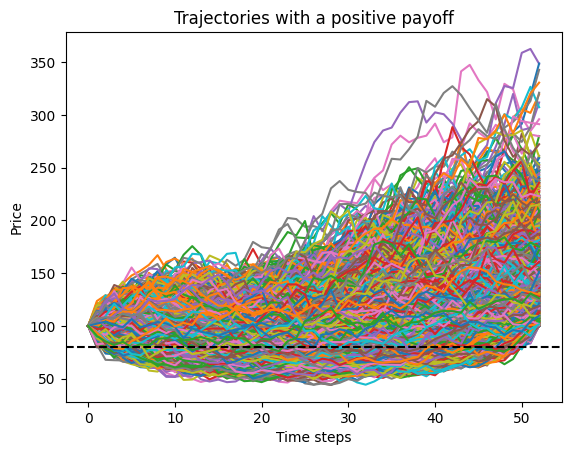

In [ ]:
# Find rows where the minimum value is below 80
min_below_80 = np.min(S, axis=1) < 80

# Find rows where the last value is above 100
last_above_100 = S[:, -1] > 100

# Combine the conditions using logical AND
subset_indices = np.logical_and(min_below_80, last_above_100)
# Subset the array based on the combined condition
subset_S = S[subset_indices]

plt.plot(subset_S.T);
plt.axhline(y=80, color='k', linestyle='--', label='Y = 80');
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('Trajectories with a positive payoff');

b) Calculate analytical approximations using the Broadie, Glasserman and Kou continuity-correction-technique



In [ ]:
# Analytical values for the Down and In Call
S_0 = 100 ; r = 0.03; T = 1; K = 100; sigma = np.array([0.2,0.4]); b = 80; m =  np.array([12,52])
simulations = 20000; n_years = T
dt = 1/m

q = 0
H = b
print('-----------------------------------------------------')
for i in range(len(m)):
  H = b
  H_new = H * np.exp(-0.5826*sigma* np.sqrt((T/m[i])) )

  H = H_new
  lam = (r - q + (sigma ** 2) / 2)/(sigma ** 2)
  y = np.log((H ** 2)/(S_0 * K))/(sigma * np.sqrt(T)) + lam * sigma * np.sqrt(T)


  C_di = S_0 * np.exp(-q * T) * ((H / S_0)  ** (2 * lam)) * norm.cdf(y) - K * np.exp(-r * T) * ((H / S_0) ** (2 * lam - 2)) * norm.cdf( y - sigma * np.sqrt(T))
  print(f'Sigma:                                {sigma[0]},   {sigma[1]}')
  print(f'The analytical values for m = {m[i]} are  {C_di[0]:.3f}, {C_di[1]:.3f},    ')
  print('-----------------------------------------------------')



-----------------------------------------------------
Sigma:                                0.2,   0.4
The analytical values for m = 12 are  0.034, 1.344,    
-----------------------------------------------------
Sigma:                                0.2,   0.4
The analytical values for m = 52 are  0.059, 1.973,    
-----------------------------------------------------


*Discussion*: Why is the price higher when the volatility is higher?

BLABLABLA

## Task 4 : Basket call and put option on two underlying stocks

*Call payoff* $= \big{(} \frac{1}{2}(S_1(T) + S_2(T)) - K \big{)}^+ $.
*Put payoff* $= \big{(} K - \frac{1}{2}(S_1(T) + S_2(T)) \big{)}^+ $.

Let $S_i(0) = 100, \sigma_i = 0.2$. For $K \in \{70, 100, 130\}$, calculate prices using the standard MC for the following two correlations (using the same r and T as before):

- a)  $\rho = 0 $
- b)  $\rho = 0.5$

*Discussion*: Why are the prices lower than in problem 1.



In [4]:

def CallPayoff(S,K):
  S1 = S[:,0,:]
  S2 = S[:,1,:]
  res = np.zeros((S1.shape[0],len(K)))
  for index in range(S1.shape[0]):
    for k in range(len(K)):
      res[index,k] = np.maximum((S1[index,-1] + S2[index,-1])/2 - K[k] ,0 )
  return res

def PutPayoff(S,K):
  S1 = S[:,0,:]
  S2 = S[:,1,:]
  res = np.zeros((S1.shape[0],len(K)))
  for index in range(S1.shape[0]):
    for k in range(len(K)):
      res[index,k] = np.maximum(K[k] - (S1[index,-1] + S2[index,-1])/2 ,0 )
  return res

def Cholesky_matrix(stocks, sigma, rho):
  # Function cholesky matrix (stocks, sigma) Return A
  Sigma_matrix = np.zeros([stocks,stocks])
  for i in range(Sigma_matrix.shape[0]):
    for j in range(Sigma_matrix.shape[1]):
      if i == j:
        Sigma_matrix[i,j] = sigma ** 2
      else:
        Sigma_matrix[i,j] = rho * sigma ** 2

  A = np.linalg.cholesky(Sigma_matrix)
  return A

def Stockprices(Z,X,r,sigma,dt):
  # Function Stockprices(Z,X,r,sigma,dt) Should return S
  S = S_0 * np.ones((Z.shape[0], Z.shape[1], Z.shape[2]+ 1 ))
  for i in range(simulations):
    for j in range(stocks):
      for t in range(1, T+1):
            S[i, j, t] = S[i, j, t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + np.sqrt(dt)  * X[i, j, t-1])
  return S




In [7]:
S_0 = 100; sigma = 0.2; K = np.array([70,100,130]); r = 0.03; T = 1
rho = np.array([0,0.5])
simulations = 20000
dt = 1
stocks = 2
print('---------------------------------------------------------------------')
for corr in rho:

  # Create a Cholesky matrix to enable dependence
  A = Cholesky_matrix(stocks, sigma, corr)

  # Generate random number cube where depth is simulations, height is stocks, width is time steps
  Z = np.random.standard_normal((simulations, stocks,  T))
  X =  A @ Z # Enforcing the dependence structure

  # Create stock price paths
  S = Stockprices(Z,X,r,sigma,dt)


  Call_payoff_discounted = np.exp(-r * T) * CallPayoff(S,K)
  Put_payoff_discounted = np.exp(-r * T) * PutPayoff(S,K)

  CallPrices = np.mean(Call_payoff_discounted, axis = 0)
  PutPrices = np.mean(Put_payoff_discounted, axis = 0)
  print(f'For correlation = {corr}                     K=70,    K=100,  K=130')
  print(f'   Call prices for the basket option at   {CallPrices[0]:.3f},  {CallPrices[1]:.3f},  {CallPrices[2]:.3f}')
  print(f'   Put  prices for the basket option at   {PutPrices[0]:.3f},   {PutPrices[1]:.3f},  {PutPrices[2]:.3f}')
  print('---------------------------------------------------------------------')



---------------------------------------------------------------------
For correlation = 0.0                     K=70,    K=100,  K=130
   Call prices for the basket option at   32.045,  7.174,  0.340
   Put  prices for the basket option at   0.011,   4.254,  26.533
---------------------------------------------------------------------
For correlation = 0.5                     K=70,    K=100,  K=130
   Call prices for the basket option at   32.036,  8.290,  0.771
   Put  prices for the basket option at   0.059,   5.426,  27.020
---------------------------------------------------------------------


In [ ]:
print(A)

[[0.2        0.        ]
 [0.1        0.17320508]]


## Task 5 : Autocall on four underlying stocks

Consider an autocall on four underlying stocks $S_1 \dots S_4 $ with nominal 100, autocall barrier at 100, coupon barrier at 95 and risk barrier at 70. The (accumulated) coupon is 10\% and the capital protection is 90\%. Let $S_i(0) = 100, r = 0.03, \sigma_i = 20\% $ and price the autocall using the following sets of correlations:
- (i) $\rho_{i,j}, = 0$
- (ii) $\rho_{i,j}, = 0.5$ for all $i \neq j $.

a) Calculate prices using standard MC

b) Find the coupon rates that makes the price 100 for both sets of correlarions

*Discussion*: Why does higher correlation imply a higher price?


In [ ]:
def Cholesky_matrix(stocks, sigma, rho):
  # Function cholesky matrix (stocks, sigma) Return A
  Sigma_matrix = np.zeros([stocks,stocks])
  for i in range(Sigma_matrix.shape[0]):
    for j in range(Sigma_matrix.shape[1]):
      if i == j:
        Sigma_matrix[i,j] = sigma ** 2
      else:
        Sigma_matrix[i,j] = rho * sigma ** 2

  A = np.linalg.cholesky(Sigma_matrix)
  return A

def Stockprices(Z,X,r,sigma,dt):
  # Function Stockprices(Z,X,r,sigma,dt) Should return S
  S = S_0 * np.ones((Z.shape[0], Z.shape[1], Z.shape[2]+ 1 ))
  for i in range(simulations):
    for j in range(stocks):
      for t in range(1, T+1):
            S[i, j, t] = S[i, j, t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + np.sqrt(dt)  * X[i, j, t-1])
  return S

def Discountvector(T,r):
  Discount_vec = np.ones((T + 1))
  for t in range(1, T+1):
    Discount_vec[t] = np.exp(-r*t)
  return Discount_vec


def Cashflow_matrix(WPS, Nominal, Coupon, T, Risk_value, ACB, CB, RB):
  # Function Cashflow_matrix(WPS, Nominal, Coupon, T, Risk_value, ACB, CB, RB) returning CF_Matrix
  CF_matrix = np.ones((simulations, T+1))
  CF_matrix[:,0]=0
  for t in range(1,T):
    for sims in range(simulations):
      if WPS[sims,t] > ACB: # Case if Autocall
        CF_matrix[sims,t] = CF_matrix[sims,t]*( Nominal + (Coupon*(t+1) - np.sum(CF_matrix[sims,:t])))
        CF_matrix[sims,t+1:] = 0 # Setting all payoffs in the future to zero if Autocalled

      elif WPS[sims,t] > CB : # Case if above coupon barrier
        CF_matrix[sims,t] = CF_matrix[sims,t]*((Coupon*(t+1) - np.sum(CF_matrix[sims,:t])))
      else: # Case if below coupon barrier
        CF_matrix[sims,t] = 0 # The payoff at this time is 0

  for sims in range(simulations):
    if WPS[sims,T] > CB: # Case if Autocall
      CF_matrix[sims,T] = CF_matrix[sims,T]*( Nominal + (Coupon * (T+1) - np.sum(CF_matrix[sims,:T])))

    elif WPS[sims,T] > RB : # Case if above coupon barrier
      CF_matrix[sims,T] = CF_matrix[sims,T]* Nominal
    else: # Case if below risk barrier
      CF_matrix[sims,T] = CF_matrix[sims,T]* Risk_value  # The payoff is 90
  return CF_matrix



In [ ]:
#Autocall
S_0 = 100; r = 0.03; sigma = 0.2; rho = np.array([0,0.5])
ACB = 100; CB = 95; RB = 70
Coupon = 8; Nominal = 100; Risk_value = 90
T = 7 # Maximum maturity of the contract
stocks = 4
simulations = 20000
dt = 1

for corr in rho:
  # Create matrix for dependence structure
  A = Cholesky_matrix(stocks, sigma, corr)

  # Generate random number cube where depth is simulations, height is stocks, width is time steps
  Z = np.random.standard_normal((simulations, stocks,  T))
  X =  A @ Z # Enforcing the dependence structure

  # Generating stock prices
  S = Stockprices(Z,X,r,sigma,dt)

  # Creating a matrix with the worst performing stock
  WPS = np.min(S, axis = 1)

  # Discount vector
  Discount_vec = Discountvector(T,r)

  # Create a cash flow matrix
  CF_matrix = Cashflow_matrix(WPS, Nominal, Coupon, T, Risk_value, ACB, CB, RB)

  # Summed present value of cash flow
  Payoffs = CF_matrix @ Discount_vec

  # Average of present discounted cash flows
  Price_estimate = np.mean(Payoffs)

  #print(Payoffs)
  print(f' The estimated price of the Autocall with correlation {corr} is {Price_estimate:.3f}')




# #print(S)
# colors = plt.cm.viridis(np.linspace(0, 1, simulations)) # To make the plot plot all four stocks in the same color
# for i in range(simulations):
#   plt.plot(S[i,:,:].T ,color = colors[i]);

#print(S)
#print(CF_matrix)



 The estimated price of the Autocall with correlation 0.0 is 90.334
 The estimated price of the Autocall with correlation 0.5 is 99.905


In [ ]:
# Finding Coupon rates

#Autocall
S_0 = 100; r = 0.03; sigma = 0.2; rho = np.array([0,0.5])
ACB = 100; CB = 95; RB = 70
Coupon = 10; Nominal = 100; Risk_value = 90
T = 7 # Maximum maturity of the contract
stocks = 4
simulations = 200000
dt = 1




for corr in rho:
  print(f'Correlation is {corr}')
  Coupon_vec = 0
  if corr == 0:
    Coupon_vec = np.arange(14.7,15.3,0.1)
  elif corr == 0.5:
    Coupon_vec = np.arange(8.5,7.8,-0.1)

  for Coupon in Coupon_vec:
    # Create matrix for dependence structure
    A = Cholesky_matrix(stocks, sigma, corr)

    # Generate random number cube where depth is simulations, height is stocks, width is time steps
    Z = np.random.standard_normal((simulations, stocks,  T))
    X =  A @ Z # Enforcing the dependence structure

    # Generating stock prices
    S = Stockprices(Z,X,r,sigma,dt)

    # Creating a matrix with the worst performing stock
    WPS = np.min(S, axis = 1)

    # Discount vector
    Discount_vec = Discountvector(T,r)

    # Create a cash flow matrix
    CF_matrix = Cashflow_matrix(WPS, Nominal, Coupon, T, Risk_value, ACB, CB, RB)

    # Summed present value of cash flow
    Payoffs = CF_matrix @ Discount_vec

    # Average of present discounted cash flows
    Price_estimate = np.mean(Payoffs)

    #print(Payoffs)

    print(f'  The estimated price of the Autocall with coupon {Coupon:.1f} is {Price_estimate:.3f}')




# #print(S)
# colors = plt.cm.viridis(np.linspace(0, 1, simulations)) # To make the plot plot all four stocks in the same color
# for i in range(simulations):
#   plt.plot(S[i,:,:].T ,color = colors[i]);

#print(S)
#print(CF_matrix)


Correlation is 0.0
  The estimated price of the Autocall with coupon 14.7 is 99.507
  The estimated price of the Autocall with coupon 14.8 is 99.578
  The estimated price of the Autocall with coupon 14.9 is 99.843
  The estimated price of the Autocall with coupon 15.0 is 99.894
  The estimated price of the Autocall with coupon 15.1 is 100.147
  The estimated price of the Autocall with coupon 15.2 is 100.075
  The estimated price of the Autocall with coupon 15.3 is 100.355
Correlation is 0.5
  The estimated price of the Autocall with coupon 8.5 is 100.822
  The estimated price of the Autocall with coupon 8.4 is 100.530
  The estimated price of the Autocall with coupon 8.3 is 100.435
  The estimated price of the Autocall with coupon 8.2 is 100.248
  The estimated price of the Autocall with coupon 8.1 is 100.048
  The estimated price of the Autocall with coupon 8.0 is 99.852
  The estimated price of the Autocall with coupon 7.9 is 99.682
  The estimated price of the Autocall with coupon 7

For correlation of 0.0 the estimated interval is between 15.0 and 15.1.

For correlation of 0.5 the estimated interval is between 8.0 and 8.1.